In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10522081852729804991, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7705005992447974031
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12724879070579211230
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15882446439
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5994337762174082148
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.applications.vgg19 import VGG19
from keras.regularizers import l2, l1
from sklearn.metrics import cohen_kappa_score, accuracy_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.14.0


In [5]:
batch_size = 32
img_height, img_width = 512, 512
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
print(os.listdir("../input/esophageal-cancer/esophageal_cancer_data/"))

['test', 'train']


In [7]:
train_dir = '../input/esophageal-cancer/esophageal_cancer_data/train/'
test_dir = '../input/esophageal-cancer/esophageal_cancer_data/test/'

In [8]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 25017 images belonging to 4 classes.
Found 8339 images belonging to 4 classes.
Found 1107 images belonging to 4 classes.


In [9]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 25017
nb_validation_samples: 8339
nb_test_samples: 1107

predict_size_train: 782
predict_size_validation: 261
predict_size_test: 35

 num_classes: 4


In [18]:
os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "MobileNet_descriptors"

In [11]:
vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
xception_weights = "../input/full-keras-pretrained-no-top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [12]:
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
from keras.applications import DenseNet121
from keras.applications import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import NASNetLarge, NASNetMobile
from keras.applications import MobileNet

In [13]:
model = VGG19(weights=vgg19_weights, include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [14]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d_1


In [15]:
# c1 = model.layers[11].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[18].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[28].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[51].output
# c4 = GlobalAveragePooling2D()(c4) 

# c5 = model.layers[74].output
# c5 = GlobalAveragePooling2D()(c5) 

# c6 = model.layers[101].output
# c6 = GlobalAveragePooling2D()(c6) 

# c7 = model.layers[120].output
# c7 = GlobalAveragePooling2D()(c7) 

# c8 = model.layers[152].output
# c8 = GlobalAveragePooling2D()(c8) 

# c9 = model.layers[184].output
# c9 = GlobalAveragePooling2D()(c9) 

# c10 = model.layers[216].output
# c10 = GlobalAveragePooling2D()(c10) 

# c11 = model.layers[248].output
# c11 = GlobalAveragePooling2D()(c11) 

# c12 = model.layers[263].output
# c12 = GlobalAveragePooling2D()(c12) 

# c13 = model.layers[294].output
# c13 = GlobalAveragePooling2D()(c13) 

# con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [16]:
bottleneck_final_model = model

In [19]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [20]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [21]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [22]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))

# reset_keras_tf_session()

In [23]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [24]:
adam_opt=Adam(lr=0.0001, beta_1=0.6, beta_2=0.99)

model = Sequential()
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

# model.add(Dense(128, activation="relu", kernel_regularizer=l2(1e-05), bias_regularizer=l2(1e-05), activity_regularizer=l1(1e-06)))
# model.add(Dropout(0.5))

# model.add(Dense(512, activation="relu", kernel_regularizer=l2(1e-06), bias_regularizer=l2(0.01), activity_regularizer=l1(1e-07)))
# model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

Train on 25017 samples, validate on 8339 samples
Epoch 1/1000
 - 4s - loss: 1.2699 - acc: 0.3962 - val_loss: 1.1919 - val_acc: 0.4879
Epoch 2/1000
 - 2s - loss: 1.1584 - acc: 0.4869 - val_loss: 1.1445 - val_acc: 0.5015
Epoch 3/1000
 - 2s - loss: 1.1115 - acc: 0.5250 - val_loss: 1.1016 - val_acc: 0.5354
Epoch 4/1000
 - 2s - loss: 1.0727 - acc: 0.5485 - val_loss: 1.0805 - val_acc: 0.5455
Epoch 5/1000
 - 2s - loss: 1.0390 - acc: 0.5667 - val_loss: 1.0524 - val_acc: 0.5592
Epoch 6/1000
 - 2s - loss: 1.0115 - acc: 0.5816 - val_loss: 1.0288 - val_acc: 0.5742
Epoch 7/1000
 - 2s - loss: 0.9868 - acc: 0.5940 - val_loss: 1.0236 - val_acc: 0.5611
Epoch 8/1000
 - 2s - loss: 0.9644 - acc: 0.6055 - val_loss: 0.9890 - val_acc: 0.5908
Epoch 9/1000
 - 2s - loss: 0.9428 - acc: 0.6178 - val_loss: 0.9894 - val_acc: 0.5875
Epoch 10/1000
 - 2s - loss: 0.9234 - acc: 0.6294 - val_loss: 0.9701 - val_acc: 0.6013
Epoch 11/1000
 - 2s - loss: 0.9074 - acc: 0.6352 - val_loss: 0.9369 - val_acc: 0.6211
Epoch 12/1000


Epoch 96/1000
 - 2s - loss: 0.5492 - acc: 0.7908 - val_loss: 0.6072 - val_acc: 0.7686
Epoch 97/1000
 - 2s - loss: 0.5472 - acc: 0.7919 - val_loss: 0.5961 - val_acc: 0.7728
Epoch 98/1000
 - 2s - loss: 0.5460 - acc: 0.7939 - val_loss: 0.6183 - val_acc: 0.7576
Epoch 99/1000
 - 2s - loss: 0.5449 - acc: 0.7936 - val_loss: 0.6205 - val_acc: 0.7598
Epoch 100/1000
 - 2s - loss: 0.5425 - acc: 0.7955 - val_loss: 0.6154 - val_acc: 0.7614
Epoch 101/1000
 - 2s - loss: 0.5405 - acc: 0.7962 - val_loss: 0.6157 - val_acc: 0.7606
Epoch 102/1000
 - 2s - loss: 0.5418 - acc: 0.7939 - val_loss: 0.6112 - val_acc: 0.7635
Epoch 103/1000
 - 2s - loss: 0.5384 - acc: 0.7995 - val_loss: 0.5891 - val_acc: 0.7741
Epoch 104/1000
 - 2s - loss: 0.5368 - acc: 0.7970 - val_loss: 0.6134 - val_acc: 0.7599
Epoch 105/1000
 - 2s - loss: 0.5363 - acc: 0.7974 - val_loss: 0.5973 - val_acc: 0.7666
Epoch 106/1000
 - 2s - loss: 0.5344 - acc: 0.7980 - val_loss: 0.6251 - val_acc: 0.7594
Epoch 107/1000
 - 2s - loss: 0.5333 - acc: 0.79

Epoch 191/1000
 - 2s - loss: 0.4489 - acc: 0.8361 - val_loss: 0.5110 - val_acc: 0.8061
Epoch 192/1000
 - 2s - loss: 0.4491 - acc: 0.8342 - val_loss: 0.5474 - val_acc: 0.7846
Epoch 193/1000
 - 2s - loss: 0.4474 - acc: 0.8351 - val_loss: 0.5170 - val_acc: 0.8081
Epoch 194/1000
 - 2s - loss: 0.4481 - acc: 0.8355 - val_loss: 0.5192 - val_acc: 0.8037
Epoch 195/1000
 - 2s - loss: 0.4456 - acc: 0.8370 - val_loss: 0.5076 - val_acc: 0.8049
Epoch 196/1000
 - 2s - loss: 0.4443 - acc: 0.8367 - val_loss: 0.5107 - val_acc: 0.8067
Epoch 197/1000
 - 2s - loss: 0.4431 - acc: 0.8359 - val_loss: 0.5214 - val_acc: 0.7903
Epoch 198/1000
 - 2s - loss: 0.4421 - acc: 0.8371 - val_loss: 0.5164 - val_acc: 0.8062
Epoch 199/1000
 - 2s - loss: 0.4419 - acc: 0.8373 - val_loss: 0.4926 - val_acc: 0.8163
Epoch 200/1000
 - 2s - loss: 0.4413 - acc: 0.8373 - val_loss: 0.5018 - val_acc: 0.8126
Epoch 201/1000
 - 2s - loss: 0.4423 - acc: 0.8369 - val_loss: 0.5249 - val_acc: 0.8001
Epoch 202/1000
 - 2s - loss: 0.4394 - acc: 

 - 2s - loss: 0.3907 - acc: 0.8593 - val_loss: 0.4643 - val_acc: 0.8265
Epoch 286/1000
 - 2s - loss: 0.3899 - acc: 0.8594 - val_loss: 0.4495 - val_acc: 0.8308
Epoch 287/1000
 - 2s - loss: 0.3905 - acc: 0.8613 - val_loss: 0.4632 - val_acc: 0.8253
Epoch 288/1000
 - 2s - loss: 0.3899 - acc: 0.8591 - val_loss: 0.4676 - val_acc: 0.8242
Epoch 289/1000
 - 2s - loss: 0.3891 - acc: 0.8601 - val_loss: 0.4755 - val_acc: 0.8202
Epoch 290/1000
 - 2s - loss: 0.3894 - acc: 0.8613 - val_loss: 0.4759 - val_acc: 0.8202
Epoch 291/1000
 - 2s - loss: 0.3857 - acc: 0.8592 - val_loss: 0.4499 - val_acc: 0.8283
Epoch 292/1000
 - 2s - loss: 0.3877 - acc: 0.8609 - val_loss: 0.4721 - val_acc: 0.8199
Epoch 293/1000
 - 2s - loss: 0.3837 - acc: 0.8609 - val_loss: 0.4585 - val_acc: 0.8304
Epoch 294/1000
 - 2s - loss: 0.3866 - acc: 0.8621 - val_loss: 0.4792 - val_acc: 0.8156
Epoch 295/1000
 - 2s - loss: 0.3831 - acc: 0.8630 - val_loss: 0.4646 - val_acc: 0.8248
Epoch 296/1000
 - 2s - loss: 0.3829 - acc: 0.8599 - val_lo

Epoch 380/1000
 - 2s - loss: 0.3510 - acc: 0.8745 - val_loss: 0.4478 - val_acc: 0.8310
Epoch 381/1000
 - 2s - loss: 0.3497 - acc: 0.8732 - val_loss: 0.4294 - val_acc: 0.8358
Epoch 382/1000
 - 2s - loss: 0.3503 - acc: 0.8736 - val_loss: 0.4206 - val_acc: 0.8424
Epoch 383/1000
 - 2s - loss: 0.3491 - acc: 0.8751 - val_loss: 0.4306 - val_acc: 0.8393
Epoch 384/1000
 - 2s - loss: 0.3474 - acc: 0.8803 - val_loss: 0.4360 - val_acc: 0.8312
Epoch 385/1000
 - 3s - loss: 0.3455 - acc: 0.8771 - val_loss: 0.4348 - val_acc: 0.8345
Epoch 386/1000
 - 2s - loss: 0.3468 - acc: 0.8769 - val_loss: 0.4526 - val_acc: 0.8322
Epoch 387/1000
 - 2s - loss: 0.3482 - acc: 0.8763 - val_loss: 0.4176 - val_acc: 0.8404
Epoch 388/1000
 - 2s - loss: 0.3474 - acc: 0.8760 - val_loss: 0.4309 - val_acc: 0.8397
Epoch 389/1000
 - 2s - loss: 0.3472 - acc: 0.8767 - val_loss: 0.4461 - val_acc: 0.8294
Epoch 390/1000
 - 2s - loss: 0.3448 - acc: 0.8772 - val_loss: 0.4484 - val_acc: 0.8296
Epoch 391/1000
 - 2s - loss: 0.3460 - acc: 

 - 2s - loss: 0.3216 - acc: 0.8862 - val_loss: 0.4085 - val_acc: 0.8471
Epoch 475/1000
 - 2s - loss: 0.3195 - acc: 0.8878 - val_loss: 0.4164 - val_acc: 0.8436
Epoch 476/1000
 - 2s - loss: 0.3196 - acc: 0.8878 - val_loss: 0.4154 - val_acc: 0.8453
Epoch 477/1000
 - 3s - loss: 0.3171 - acc: 0.8890 - val_loss: 0.3969 - val_acc: 0.8479
Epoch 478/1000
 - 2s - loss: 0.3179 - acc: 0.8880 - val_loss: 0.4100 - val_acc: 0.8475
Epoch 479/1000
 - 2s - loss: 0.3188 - acc: 0.8866 - val_loss: 0.3991 - val_acc: 0.8495
Epoch 480/1000
 - 2s - loss: 0.3167 - acc: 0.8896 - val_loss: 0.4556 - val_acc: 0.8208
Epoch 481/1000
 - 2s - loss: 0.3159 - acc: 0.8895 - val_loss: 0.4582 - val_acc: 0.8278
Epoch 482/1000
 - 2s - loss: 0.3165 - acc: 0.8865 - val_loss: 0.4203 - val_acc: 0.8427
Epoch 483/1000
 - 2s - loss: 0.3163 - acc: 0.8885 - val_loss: 0.4612 - val_acc: 0.8250
Epoch 484/1000
 - 2s - loss: 0.3175 - acc: 0.8881 - val_loss: 0.4034 - val_acc: 0.8497
Epoch 485/1000
 - 2s - loss: 0.3141 - acc: 0.8884 - val_lo

Epoch 569/1000
 - 2s - loss: 0.2970 - acc: 0.8956 - val_loss: 0.4109 - val_acc: 0.8448
Epoch 570/1000
 - 2s - loss: 0.2973 - acc: 0.8967 - val_loss: 0.3807 - val_acc: 0.8557
Epoch 571/1000
 - 2s - loss: 0.2946 - acc: 0.8971 - val_loss: 0.3937 - val_acc: 0.8502
Epoch 572/1000
 - 2s - loss: 0.2989 - acc: 0.8956 - val_loss: 0.4621 - val_acc: 0.8250
Epoch 573/1000
 - 2s - loss: 0.2918 - acc: 0.8987 - val_loss: 0.3917 - val_acc: 0.8544
Epoch 574/1000
 - 2s - loss: 0.2938 - acc: 0.8964 - val_loss: 0.3772 - val_acc: 0.8595
Epoch 575/1000
 - 2s - loss: 0.2941 - acc: 0.8970 - val_loss: 0.3792 - val_acc: 0.8583
Epoch 576/1000
 - 2s - loss: 0.2959 - acc: 0.8964 - val_loss: 0.3896 - val_acc: 0.8525
Epoch 577/1000
 - 2s - loss: 0.2930 - acc: 0.8973 - val_loss: 0.3783 - val_acc: 0.8572
Epoch 578/1000
 - 2s - loss: 0.2955 - acc: 0.8961 - val_loss: 0.3838 - val_acc: 0.8553
Epoch 579/1000
 - 2s - loss: 0.2923 - acc: 0.8968 - val_loss: 0.3819 - val_acc: 0.8560
Epoch 580/1000
 - 2s - loss: 0.2923 - acc: 

 - 2s - loss: 0.2778 - acc: 0.9033 - val_loss: 0.4083 - val_acc: 0.8487
Epoch 664/1000
 - 2s - loss: 0.2760 - acc: 0.9034 - val_loss: 0.3611 - val_acc: 0.8604
Epoch 665/1000
 - 2s - loss: 0.2767 - acc: 0.9054 - val_loss: 0.3662 - val_acc: 0.8591
Epoch 666/1000
 - 2s - loss: 0.2732 - acc: 0.9055 - val_loss: 0.3607 - val_acc: 0.8638
Epoch 667/1000
 - 2s - loss: 0.2825 - acc: 0.9023 - val_loss: 0.3903 - val_acc: 0.8513
Epoch 668/1000
 - 2s - loss: 0.2747 - acc: 0.9047 - val_loss: 0.3581 - val_acc: 0.8664
Epoch 669/1000
 - 2s - loss: 0.2757 - acc: 0.9035 - val_loss: 0.3903 - val_acc: 0.8535
Epoch 670/1000
 - 3s - loss: 0.2775 - acc: 0.9037 - val_loss: 0.3678 - val_acc: 0.8607
Epoch 671/1000
 - 2s - loss: 0.2752 - acc: 0.9041 - val_loss: 0.4079 - val_acc: 0.8475
Epoch 672/1000
 - 3s - loss: 0.2726 - acc: 0.9042 - val_loss: 0.3761 - val_acc: 0.8555
Epoch 673/1000
 - 2s - loss: 0.2763 - acc: 0.9033 - val_loss: 0.4328 - val_acc: 0.8376
Epoch 674/1000
 - 2s - loss: 0.2755 - acc: 0.9042 - val_lo

Epoch 758/1000
 - 2s - loss: 0.2609 - acc: 0.9098 - val_loss: 0.3739 - val_acc: 0.8583
Epoch 759/1000
 - 2s - loss: 0.2653 - acc: 0.9087 - val_loss: 0.3660 - val_acc: 0.8635
Epoch 760/1000
 - 2s - loss: 0.2643 - acc: 0.9079 - val_loss: 0.3586 - val_acc: 0.8669
Epoch 761/1000
 - 2s - loss: 0.2615 - acc: 0.9097 - val_loss: 0.3925 - val_acc: 0.8515
Epoch 762/1000
 - 2s - loss: 0.2605 - acc: 0.9095 - val_loss: 0.3717 - val_acc: 0.8592
Epoch 763/1000
 - 2s - loss: 0.2626 - acc: 0.9091 - val_loss: 0.3663 - val_acc: 0.8655
Epoch 764/1000
 - 2s - loss: 0.2615 - acc: 0.9098 - val_loss: 0.3477 - val_acc: 0.8707
Epoch 765/1000
 - 2s - loss: 0.2574 - acc: 0.9116 - val_loss: 0.4018 - val_acc: 0.8490
Epoch 766/1000
 - 2s - loss: 0.2579 - acc: 0.9110 - val_loss: 0.3591 - val_acc: 0.8665
Epoch 767/1000
 - 2s - loss: 0.2599 - acc: 0.9093 - val_loss: 0.3651 - val_acc: 0.8653
Epoch 768/1000
 - 2s - loss: 0.2604 - acc: 0.9118 - val_loss: 0.3840 - val_acc: 0.8536
Epoch 769/1000
 - 2s - loss: 0.2620 - acc: 

 - 3s - loss: 0.2456 - acc: 0.9141 - val_loss: 0.3737 - val_acc: 0.8589
Epoch 853/1000
 - 2s - loss: 0.2480 - acc: 0.9147 - val_loss: 0.3512 - val_acc: 0.8684
Epoch 854/1000
 - 2s - loss: 0.2474 - acc: 0.9125 - val_loss: 0.3454 - val_acc: 0.8706
Epoch 855/1000
 - 2s - loss: 0.2481 - acc: 0.9157 - val_loss: 0.3378 - val_acc: 0.8768
Epoch 856/1000
 - 2s - loss: 0.2464 - acc: 0.9164 - val_loss: 0.3453 - val_acc: 0.8717
Epoch 857/1000
 - 2s - loss: 0.2484 - acc: 0.9151 - val_loss: 0.3671 - val_acc: 0.8602
Epoch 858/1000
 - 2s - loss: 0.2493 - acc: 0.9145 - val_loss: 0.3635 - val_acc: 0.8641
Epoch 859/1000
 - 2s - loss: 0.2445 - acc: 0.9135 - val_loss: 0.3531 - val_acc: 0.8690
Epoch 860/1000
 - 2s - loss: 0.2504 - acc: 0.9125 - val_loss: 0.3626 - val_acc: 0.8656
Epoch 861/1000
 - 2s - loss: 0.2489 - acc: 0.9143 - val_loss: 0.4193 - val_acc: 0.8429
Epoch 862/1000
 - 2s - loss: 0.2439 - acc: 0.9157 - val_loss: 0.3630 - val_acc: 0.8623
Epoch 863/1000
 - 2s - loss: 0.2450 - acc: 0.9151 - val_lo

Epoch 947/1000
 - 2s - loss: 0.2331 - acc: 0.9217 - val_loss: 0.3944 - val_acc: 0.8543
Epoch 948/1000
 - 2s - loss: 0.2378 - acc: 0.9208 - val_loss: 0.3663 - val_acc: 0.8622
Epoch 949/1000
 - 2s - loss: 0.2374 - acc: 0.9187 - val_loss: 0.3592 - val_acc: 0.8640
Epoch 950/1000
 - 2s - loss: 0.2334 - acc: 0.9203 - val_loss: 0.3422 - val_acc: 0.8742
Epoch 951/1000
 - 2s - loss: 0.2356 - acc: 0.9201 - val_loss: 0.3422 - val_acc: 0.8717
Epoch 952/1000
 - 2s - loss: 0.2366 - acc: 0.9177 - val_loss: 0.3559 - val_acc: 0.8682
Epoch 953/1000
 - 2s - loss: 0.2374 - acc: 0.9186 - val_loss: 0.3223 - val_acc: 0.8821
Epoch 954/1000
 - 2s - loss: 0.2332 - acc: 0.9186 - val_loss: 0.3692 - val_acc: 0.8607
Epoch 955/1000
 - 2s - loss: 0.2370 - acc: 0.9189 - val_loss: 0.3578 - val_acc: 0.8682
Epoch 956/1000
 - 3s - loss: 0.2365 - acc: 0.9176 - val_loss: 0.3611 - val_acc: 0.8656
Epoch 957/1000
 - 3s - loss: 0.2362 - acc: 0.9173 - val_loss: 0.3485 - val_acc: 0.8714
Epoch 958/1000
 - 2s - loss: 0.2346 - acc: 

In [25]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

8339/8339 [==============================] - 0s 37us/step
Validation Accuracy: 87.4206%
Validation Loss: 0.344745987334945


In [26]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

from sklearn.metrics import accuracy_score, confusion_matrix
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Test Accuracy: {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Test Accuracy: 0.37759710930442636


Confusion Matrix
[[418   0   0   0]
 [141   0   0   0]
 [375   0   0   0]
 [173   0   0   0]]


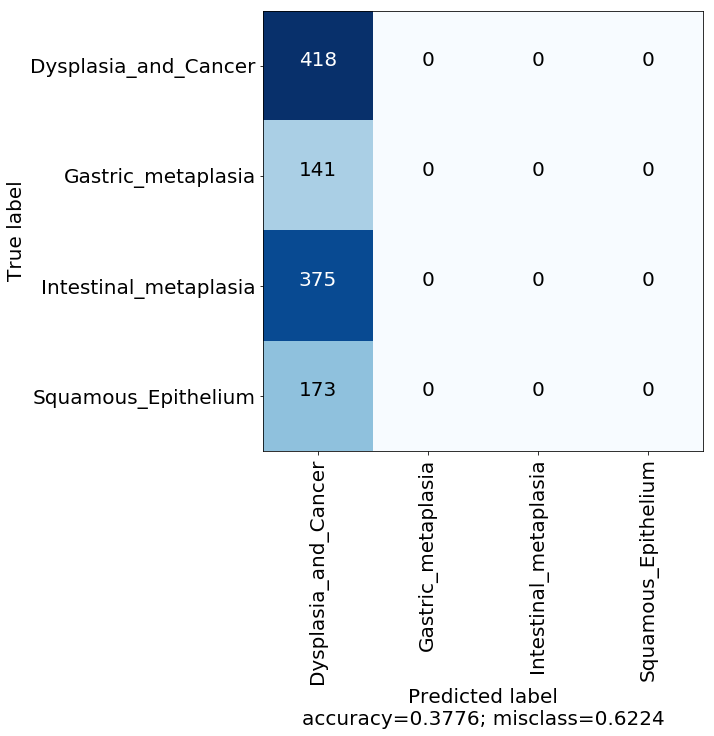

In [27]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[418   0   0   0]
 [141   0   0   0]
 [375   0   0   0]
 [173   0   0   0]]
                       precision    recall  f1-score   support

 Dysplasia_and_Cancer       0.38      1.00      0.55       418
   Gastric_metaplasia       0.00      0.00      0.00       141
Intestinal_metaplasia       0.00      0.00      0.00       375
  Squamous_Epithelium       0.00      0.00      0.00       173

             accuracy                           0.38      1107
            macro avg       0.09      0.25      0.14      1107
         weighted avg       0.14      0.38      0.21      1107



In [29]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.7477638640429338
Specificity :  nan


In [30]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

1107/1107 [==============================] - 0s 26us/step
Precision =  0.1425795769550589
Recall =  0.37759710930442636
f1_score =  0.20699749729737732


In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.5


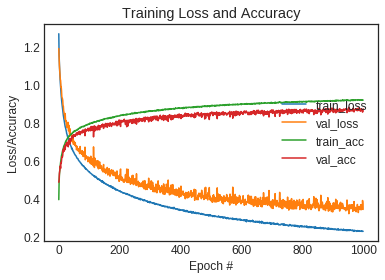

In [32]:
plt.rcParams.update({'font.size': 12})

import seaborn
plt.style.use('seaborn-white')

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

plt.legend(loc="center right")